In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import fast_AMM_sim_functions as sim
import pickle
from scipy.interpolate import interp1d

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
date = '2025-01'
total_buy_volume = 23500.

In [3]:
# Market Parameters

T = 31 # Time horizon
N = 43198 # Number of periods
dt = T/N # Time increment
buy_rate = 3000. # Purchase rate per unit time for systematic buyers
sell_rate = buy_rate # Sale rate per unit time for systematic sellers
buy = buy_rate*dt # Constant trade size for systematic buyers
sell = -sell_rate*dt # Constant trade size for systematic sellers
eta0 = 0.0035 # CEX proportional cost
X = 23000000 # Initial CPMM Dollar Reserves
S = 3331.51 # Initial CEX Price
Y = X/S # Initial CPMM Asset Reserves

mu = 0.0  # Mean of CEX price shock
sigma_0 = 0.037 # Initial volatility
M = 1 # Total number of sims
time = np.array([i * dt for i in range(N+1)]) # Time grid

In [4]:


# Set constant fee

eta1 = 0.0035

In [5]:
# Run Simulation

S0 = sim.CEX_Price(S, mu, sigma_0, dt, N, M) # Generate price series

filtr_bfs , filtr_sfs =  sim.generate_trade_filters(N, M) # Generate buyer-first/seller-first trade filter

X_reserves, Y_reserves, ref_price, amm_price, buy_vol, sell_vol, arb_vol, buy_rev, sell_rev, arb_rev, hedge_val= \
                        sim.fast_simulation(M, N, T, dt, buy, sell, eta0, eta1, S0, X, Y, filtr_bfs, filtr_sfs) # Market simulation

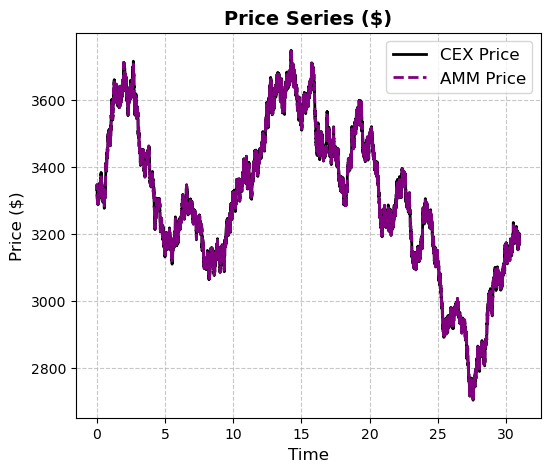

In [6]:
# Plot CEX price and AMM price
plt.figure(figsize=(6, 5)) # Set figure size
plt.plot(time, ref_price[:,:5], color="black", linestyle="-", linewidth=2, label="CEX Price") 
plt.plot(time, amm_price[:,:5], color="purple", linestyle="--", linewidth=2, label="AMM Price") 

# Title and labels
plt.title("Price Series ($)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)

# Legend
plt.legend(loc="best", fontsize=12)

# Grid
plt.grid(True, linestyle="--", alpha=0.7)

# Show plot
plt.show()


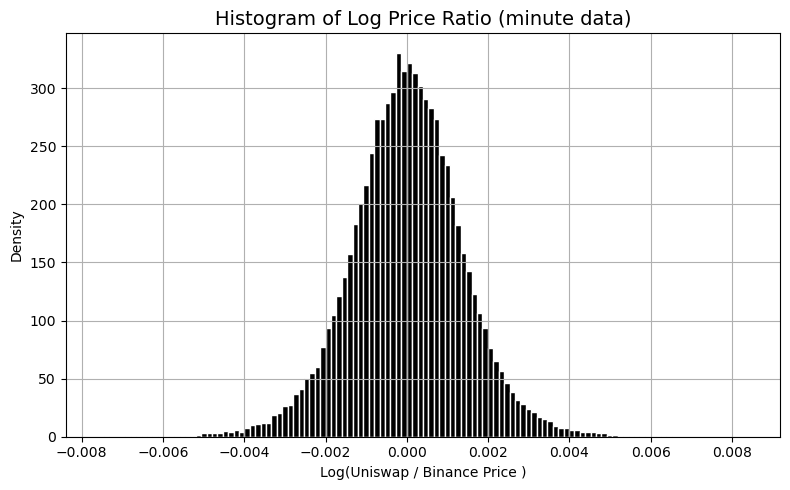

In [7]:
log_ratio = np.log(amm_price[:-1]/ref_price[1:])

plt.figure(figsize=(8, 5))
plt.hist(log_ratio, bins=120, color='k', edgecolor='white', density=True)

plt.title('Histogram of Log Price Ratio (minute data)', fontsize=14)
plt.xlabel('Log(Uniswap / Binance Price )')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'log_ratio_sim_{date}_eta0={eta0}.pdf')
plt.show()

Calibration

In [8]:
import optuna
from optuna.samplers import QMCSampler, TPESampler
import pickle

In [9]:
with open(f"hist_dist_{date}.pkl", "rb") as f:
    hist_dist = pickle.load(f)

L1 distance: 0.4458511006966317
L2 distance: 5.999932116363028


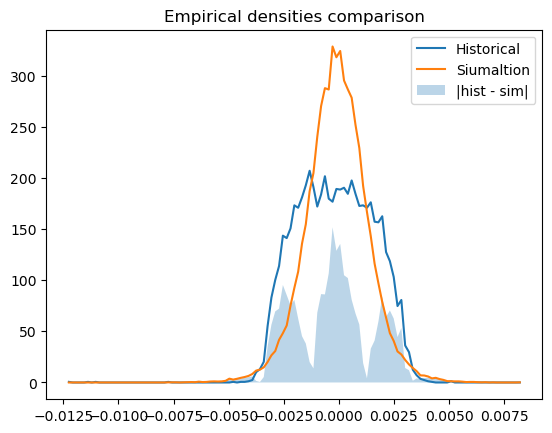

In [10]:
# Définir des bins communs pour les deux distributions
bins = np.linspace(min(hist_dist.min(), log_ratio.min()), max(hist_dist.max(), log_ratio.max()), 120)

# Histogrammes normalisés (densité)
hist1, _ = np.histogram(hist_dist, bins=bins, density=True)
hist2, _ = np.histogram(log_ratio, bins=bins, density=True)

# Comparaison des densités empiriques
abs_diff = np.abs(hist1 - hist2)
l1_distance = np.sum(abs_diff) * (bins[1] - bins[0])       # aire sous la courbe |p1 - p2|
l2_distance = np.sqrt(np.sum((hist1 - hist2)**2) * (bins[1] - bins[0]))  # distance quadratique

print("L1 distance:", l1_distance)
print("L2 distance:", l2_distance)

# Optionnel : visualiser
plt.plot(bins[:-1], hist1, label='Historical')
plt.plot(bins[:-1], hist2, label='Siumaltion')
plt.fill_between(bins[:-1], abs_diff, alpha=0.3, label='|hist - sim|')
plt.legend()
plt.title("Empirical densities comparison")
plt.show()

In [11]:
def comparison_densities(params):

    buy_rate = params[0] # Purchase rate per unit time for systematic buyers
    sell_rate = buy_rate # Sale rate per unit time for systematic sellers
    buy = buy_rate*dt # Constant trade size for systematic buyers
    sell = -sell_rate*dt # Constant trade size for systematic sellers

    eta0 = params[1]

    sigma = params[2]

    S0 = sim.CEX_Price(S, mu, sigma, dt, N, M) # Generate price series


    
    filtr_bfs , filtr_sfs =  sim.generate_trade_filters(N, M) # Generate buyer-first/seller-first trade filter

    X_reserves, Y_reserves, ref_price, amm_price, buy_vol, sell_vol, arb_vol, buy_rev, sell_rev, arb_rev, hedge_val= \
                        sim.fast_simulation(M, N, T, dt, buy, sell, eta0, eta1, S0, X, Y, filtr_bfs, filtr_sfs) # Market simulation
    
    log_ratio = np.log(amm_price[:-1]/ref_price[1:])

    bins = np.linspace(min(hist_dist.min(), log_ratio.min()), max(hist_dist.max(), log_ratio.max()), 120)

    # Histogrammes normalisés (densité)
    hist1, _ = np.histogram(hist_dist, bins=bins, density=True)
    hist2, _ = np.histogram(log_ratio, bins=bins, density=True)

    # Comparaison des densités empiriques
    l2_distance = np.sqrt(np.sum((hist1 - hist2)**2) * (bins[1] - bins[0]))  # distance quadratique
    
    return l2_distance 

In [12]:
def objective(trial):
    buy_rate = trial.suggest_float('buy_rate', 1000., 20000.)
    eta0 = trial.suggest_float('eta0', 0.0006, 0.0035)
    sigma = trial.suggest_float('sigma', 0.0, 0.08)
    params = buy_rate, eta0, sigma
    
    return comparison_densities(params)

In [13]:
study = optuna.create_study(sampler=TPESampler(seed = 0))

[I 2025-08-01 12:49:56,306] A new study created in memory with name: no-name-3101218d-e588-4fd1-b812-2096066f9b72


In [14]:
%%time


#study.enqueue_trial({'buy_rate': 1000., 'eta0': 0.01})
study.optimize(objective, n_trials=2000)

[I 2025-08-01 12:49:56,324] Trial 0 finished with value: 3.908238149499938 and parameters: {'buy_rate': 11427.456574619171, 'eta0': 0.0026740491624800164, 'sigma': 0.04822107008573151}. Best is trial 0 with value: 3.908238149499938.
[I 2025-08-01 12:49:56,335] Trial 1 finished with value: 2.077240997618776 and parameters: {'buy_rate': 11352.78047694104, 'eta0': 0.0018285989180828236, 'sigma': 0.05167152904533249}. Best is trial 1 with value: 2.077240997618776.
[I 2025-08-01 12:49:56,347] Trial 2 finished with value: 3.205125015342829 and parameters: {'buy_rate': 9314.157013991158, 'eta0': 0.0031861417022680315, 'sigma': 0.07709302084008235}. Best is trial 1 with value: 2.077240997618776.
[I 2025-08-01 12:49:56,358] Trial 3 finished with value: 5.711150521063198 and parameters: {'buy_rate': 8285.388857689777, 'eta0': 0.0028960026104397274, 'sigma': 0.04231159358023236}. Best is trial 1 with value: 2.077240997618776.
[I 2025-08-01 12:49:56,369] Trial 4 finished with value: 31.82181354218

CPU times: user 54.8 s, sys: 808 ms, total: 55.6 s
Wall time: 56.5 s


In [15]:
study.best_params

{'buy_rate': 10337.661614000766,
 'eta0': 0.0011781803107470562,
 'sigma': 0.026005104354202634}

Simulation avec ces paramètres

In [16]:
buy_rate = study.best_params['buy_rate'] # Purchase rate per unit time for systematic buyers
sell_rate = buy_rate # Sale rate per unit time for systematic sellers
buy = buy_rate*dt # Constant trade size for systematic buyers
sell = -sell_rate*dt # Constant trade size for systematic sellers
eta0 = study.best_params['eta0'] # CEX proportional cost
sigma = study.best_params['sigma']

In [17]:
mult=10
M=100
S0 = sim.CEX_Price(S, mu, sigma, dt, mult*N, M) # Generate price series


filtr_bfs , filtr_sfs =  sim.generate_trade_filters(mult*N, M) # Generate buyer-first/seller-first trade filter

X_reserves, Y_reserves, ref_price, amm_price, buy_vol, sell_vol, arb_vol, buy_rev, sell_rev, arb_rev, hedge_val= \
                        sim.fast_simulation(M, mult*N, mult*T, dt, buy, sell, eta0, eta1, S0, X, Y, filtr_bfs, filtr_sfs) # Market simulation

In [18]:
total_buy_vol_sim = np.sum(buy_vol)/mult/M

dist_vol = np.abs(total_buy_vol_sim - total_buy_volume)
print(total_buy_vol_sim)
print(total_buy_volume)
print(dist_vol/total_buy_volume*1.2)


6899.705498641594
23500.0
0.8476746128353229


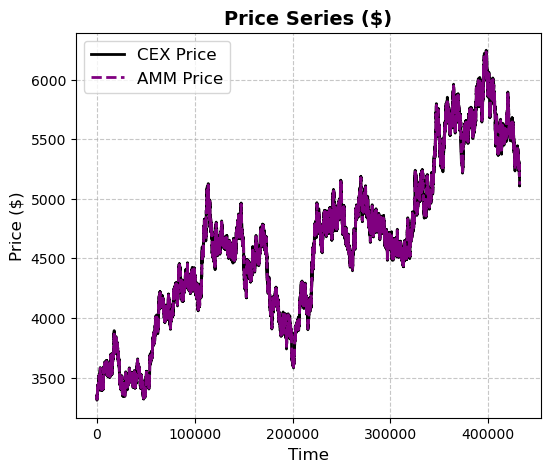

In [19]:
# Plot CEX price and AMM price
plt.figure(figsize=(6, 5)) # Set figure size
plt.plot(ref_price[:,:1], color="black", linestyle="-", linewidth=2, label="CEX Price") 
plt.plot(amm_price[:,:1], color="purple", linestyle="--", linewidth=2, label="AMM Price") 

# Title and labels
plt.title("Price Series ($)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)

# Legend
plt.legend(loc="best", fontsize=12)

# Grid
plt.grid(True, linestyle="--", alpha=0.7)

# Show plot
plt.show()

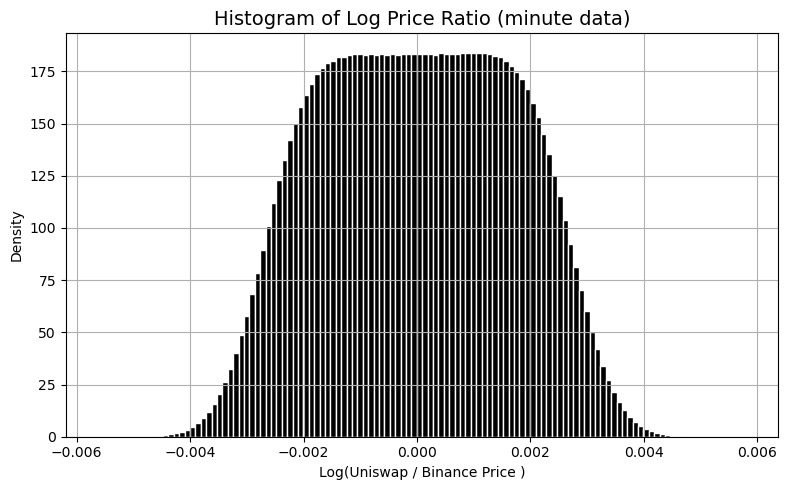

In [20]:
log_ratio = np.log(amm_price[:-1,:]/ref_price[1:,:]).flatten()

plt.figure(figsize=(8, 5))
plt.hist(log_ratio, bins=120, color='k', edgecolor='white', density=True)

plt.title('Histogram of Log Price Ratio (minute data)', fontsize=14)
plt.xlabel('Log(Uniswap / Binance Price )')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'log_ratio_sim_{date}_eta0={eta0}.pdf')
plt.show()

L1 distance: 0.08103580858369283
L2 distance: 1.0731861427743983


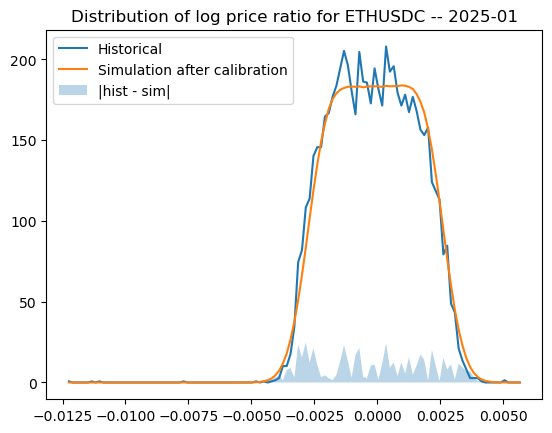

In [21]:
# Définir des bins communs pour les deux distributions
bins = np.linspace(min(hist_dist.min(), log_ratio.min()), max(hist_dist.max(), log_ratio.max()), 120)

# Histogrammes normalisés (densité)
hist1, _ = np.histogram(hist_dist, bins=bins, density=True)
hist2, _ = np.histogram(log_ratio, bins=bins, density=True)

# Comparaison des densités empiriques
abs_diff = np.abs(hist1 - hist2)
l1_distance = np.sum(abs_diff) * (bins[1] - bins[0])       # aire sous la courbe |p1 - p2|
l2_distance = np.sqrt(np.sum((hist1 - hist2)**2) * (bins[1] - bins[0]))  # distance quadratique

print("L1 distance:", l1_distance)
print("L2 distance:", l2_distance)

# Optionnel : visualiser
plt.plot(bins[:-1], hist1, label='Historical')
plt.plot(bins[:-1], hist2, label='Simulation after calibration')
plt.fill_between(bins[:-1], abs_diff, alpha=0.3, label='|hist - sim|')
plt.legend(loc='upper left')
plt.title(f"Distribution of log price ratio for ETHUSDC -- {date}")
plt.savefig(f'calib_ETHUSDC_{date}.pdf')
plt.show()

L1 distance: 0.08103580858369283
L2 distance: 1.0731861427743983


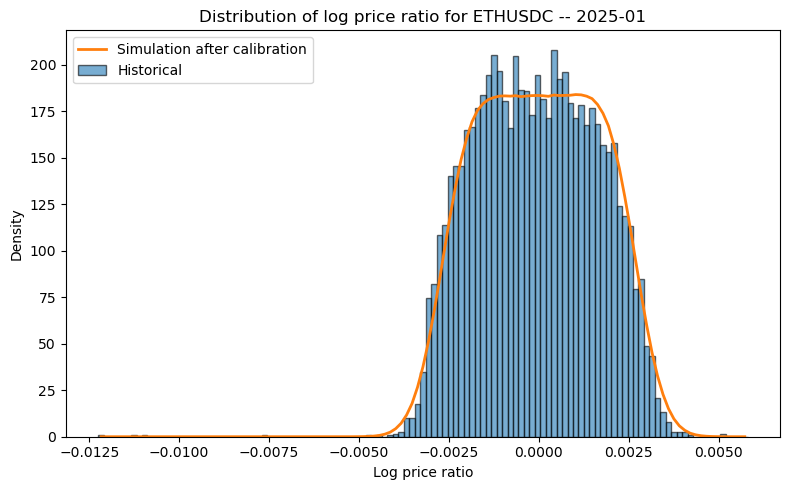

In [22]:
# Définir des bins communs pour les deux distributions
bins = np.linspace(min(hist_dist.min(), log_ratio.min()), max(hist_dist.max(), log_ratio.max()), 120)
bin_centers = (bins[:-1] + bins[1:]) / 2  # centres des bins

# Histogrammes normalisés (densité)
hist1, _ = np.histogram(hist_dist, bins=bins, density=True)
hist2, _ = np.histogram(log_ratio, bins=bins, density=True)

# Comparaison des densités empiriques
abs_diff = np.abs(hist1 - hist2)
l1_distance = np.sum(abs_diff) * (bins[1] - bins[0])
l2_distance = np.sqrt(np.sum((hist1 - hist2)**2) * (bins[1] - bins[0]))

print("L1 distance:", l1_distance)
print("L2 distance:", l2_distance)

# Visualisation
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, hist1, width=(bins[1] - bins[0]), alpha=0.6, label='Historical', color='C0', edgecolor='black')
plt.plot(bin_centers, hist2, label='Simulation after calibration', color='C1', linewidth=2)

plt.legend(loc='upper left')
plt.title(f"Distribution of log price ratio for ETHUSDC -- {date}")
plt.xlabel("Log price ratio")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f'calib_ETHUSDC_{date}.pdf')
plt.show()
